In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
warnings.filterwarnings('ignore', category=UserWarning, message="Line Search failed")

In [3]:
#load data and preprocess
data = pd.read_csv("/content/drive/MyDrive/ML_HW_4_5/labelled data.csv",index_col=0).fillna(0)
print(data.head())
print(data.isnull().sum())

      Name        FC     logFC    logCPM   P-Value       FDR  SCLC  NSCLC
0  KRT16P5 -1.474275 -0.560006 -2.065784  0.423250  0.645529   0.0    0.0
1  KRT16P3 -1.158475 -0.212227  0.698547  0.598622  0.779482   0.0    0.0
2  KRT16P2  1.785481  0.836313  3.744968  0.060200  0.211667   0.0    0.0
3  KRT16P6 -2.534136 -1.341494  0.404997  0.023716  0.123727   0.0    0.0
4    CRHBP  1.441891  0.527962 -0.015277  0.034942  0.153404   0.0    0.0
Name       0
FC         0
logFC      0
logCPM     0
P-Value    0
FDR        0
SCLC       0
NSCLC      0
dtype: int64


In [4]:
print(data.shape)
print()
print(data.describe)
print()
print(data.info)
print()
print(data.duplicated())
print()
print(data.dtypes)

(19778, 8)

<bound method NDFrame.describe of                Name        FC     logFC    logCPM   P-Value       FDR  SCLC  \
0           KRT16P5 -1.474275 -0.560006 -2.065784  0.423250  0.645529   0.0   
1           KRT16P3 -1.158475 -0.212227  0.698547  0.598622  0.779482   0.0   
2           KRT16P2  1.785481  0.836313  3.744968  0.060200  0.211667   0.0   
3           KRT16P6 -2.534136 -1.341494  0.404997  0.023716  0.123727   0.0   
4             CRHBP  1.441891  0.527962 -0.015277  0.034942  0.153404   0.0   
...             ...       ...       ...       ...       ...       ...   ...   
19773  LOC105369958  2.196994  1.135531  1.382694  0.003199  0.040235   0.0   
19774         ABCC2  3.461301  1.791314  5.336636  0.000671  0.015864   0.0   
19775         TRAV6  3.849574  1.944699 -0.401490  0.000016  0.001372   0.0   
19776  LOC105369904  2.226049  1.154485 -1.006838  0.002616  0.035713   0.0   
19777  LOC101928636  2.279563  1.188757  0.151617  0.000219  0.007721   0.0   

     

In [5]:
print(data.columns[data.isna().any()])
print()

Index([], dtype='object')



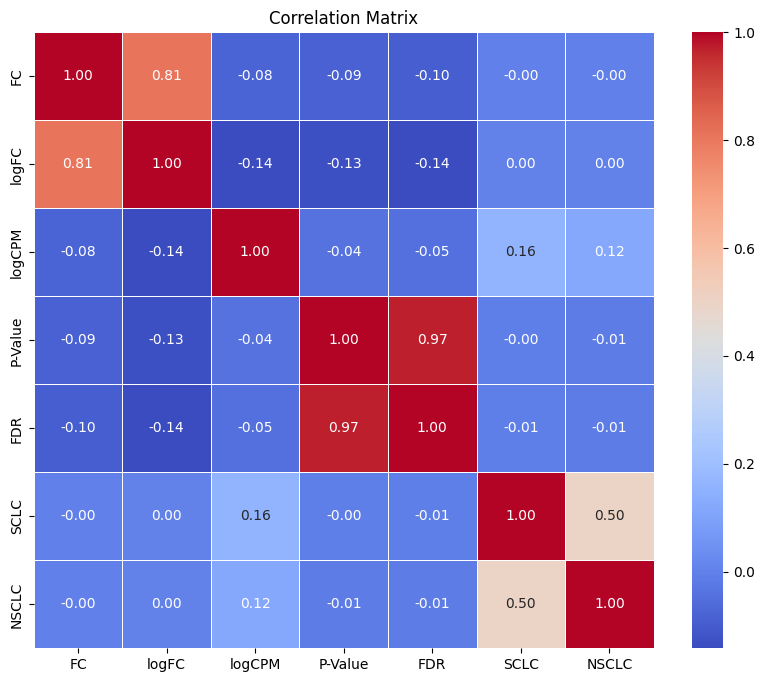

In [6]:
correlation_matrix = data.corr()
# Create a heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()

In [7]:
#feature selection
features = data[['FC', 'logFC', 'P-Value']]
targets = {'NSCLC': data['NSCLC'], 'SCLC': data['SCLC']}

In [8]:
nsclc = data['NSCLC']
sclc = data['SCLC']

In [9]:
nm = NearMiss()
print('SCLC Original Shape:', Counter(sclc))
features_nm_sclc, nm_sclc = nm.fit_resample(features, sclc)
print('SCLC Resample Shape:', Counter(nm_sclc))
print('NSCLC Original Shape:', Counter(nsclc))
features_nm_nsclc, nm_nsclc = nm.fit_resample(features, nsclc)
print('NSCLC Resample Shape:', Counter(nm_nsclc))

SCLC Original Shape: Counter({0.0: 18857, 1.0: 921})
SCLC Resample Shape: Counter({0.0: 921, 1.0: 921})
NSCLC Original Shape: Counter({0.0: 19087, 1.0: 691})
NSCLC Resample Shape: Counter({0.0: 691, 1.0: 691})


In [10]:
features_sclc = features_nm_sclc
features_nsclc = features_nm_nsclc
sclc = nm_sclc
nsclc = nm_nsclc

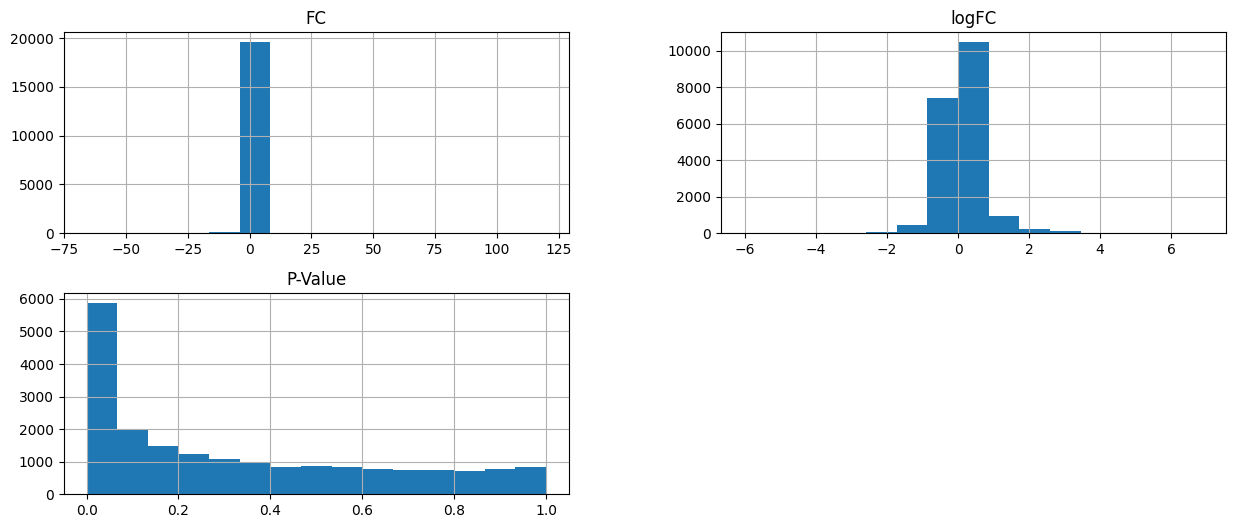

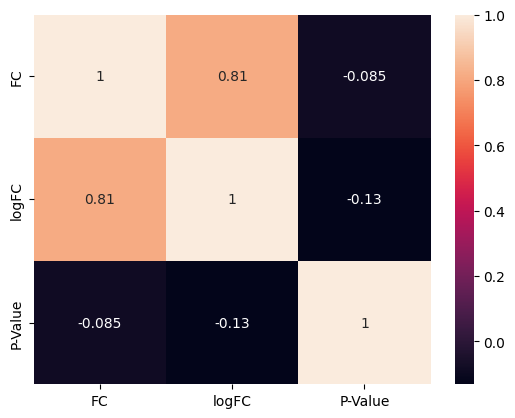

In [11]:
#EDA
#histograms and correlation matrix
features.hist(bins=15, figsize=(15, 6), layout=(2, 2))
plt.show()
sns.heatmap(features.corr(), annot=True)
plt.show()

In [12]:

#data splitting
def train_test_and_standardize(features, target, test_size=0.2, random_state=42):
    # Split the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=random_state)

    # Standardize the features using StandardScaler
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    return x_train, x_test, y_train, y_test

In [13]:
xtrain_sclc, xtest_sclc, ytrain_sclc, ytest_sclc = train_test_and_standardize(features_sclc, sclc)
xtrain_nsclc, xtest_nsclc, ytrain_nsclc, ytest_nsclc = train_test_and_standardize(features_nsclc, nsclc)

In [14]:
# Random forest pipeline
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(class_weight='balanced', n_jobs=-1))
])
# Parameter grid for random forest
param_grid_rf = {
    'rf__n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_depth': [int(x) for x in np.linspace(10, 110, num=11)],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False],
}

In [15]:
#RandomForest
def evaluate_random_forest(x_train, y_train, x_test, y_test, param_grid):
    grid_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=100, cv=3, verbose=1, n_jobs=-1)
    grid_search.fit(x_train, y_train)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    best_rf = pipeline.set_params(**best_params)
    best_rf.fit(x_train, y_train)
    y_test_pred = best_rf.predict(x_test)
    report = classification_report(y_test, y_test_pred)
    return best_params, best_score, report, y_test_pred

In [16]:
#Evaluate for NSCLC
best_params_nsclc, best_score_nsclc, report_nsclc, y_test_pred_nsclc = evaluate_random_forest(xtrain_nsclc, ytrain_nsclc, xtest_nsclc, ytest_nsclc, param_grid_rf)
print("Best Parameters for NSCLC:", best_params_nsclc)
print("Best F1 Score for NSCLC:", best_score_nsclc)
print("Classification Report for NSCLC (Test Data):\n", report_nsclc)
cm = confusion_matrix(ytest_nsclc, y_test_pred_nsclc)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters for NSCLC: {'rf__n_estimators': 1000, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 2, 'rf__max_depth': 50, 'rf__criterion': 'gini', 'rf__bootstrap': True}
Best F1 Score for NSCLC: 0.8398310160637839
Classification Report for NSCLC (Test Data):
               precision    recall  f1-score   support

         0.0       0.79      0.90      0.84       142
         1.0       0.88      0.74      0.80       135

    accuracy                           0.82       277
   macro avg       0.83      0.82      0.82       277
weighted avg       0.83      0.82      0.82       277



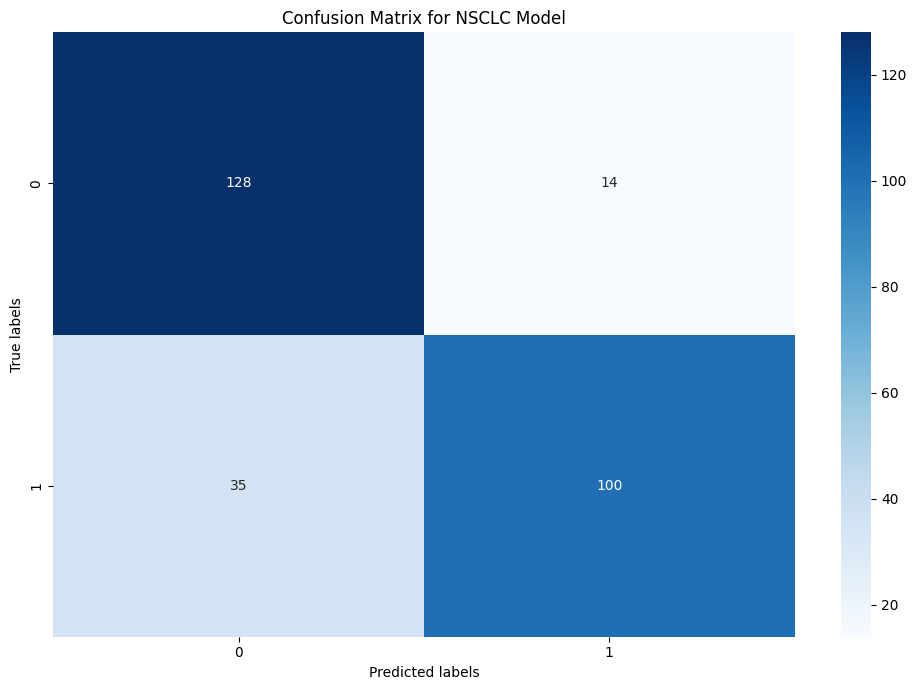

In [18]:
# Create a confusion matrix visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Adding labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for NSCLC Model')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [19]:
#Evaluate for SCLC
best_params_sclc, best_score_sclc, report_sclc, y_test_pred_sclc = evaluate_random_forest(xtrain_sclc, ytrain_sclc, xtest_sclc, ytest_sclc, param_grid_rf)
print("Best Parameters for SCLC:", best_params_sclc)
print("Best F1 Score for SCLC:", best_score_sclc)
print("Classification Report for SCLC (Test Data):\n", report_sclc)
cm_sclc = confusion_matrix(ytest_sclc, y_test_pred_sclc)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters for SCLC: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_depth': 70, 'rf__criterion': 'entropy', 'rf__bootstrap': True}
Best F1 Score for SCLC: 0.8187372708757638
Classification Report for SCLC (Test Data):
               precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       188
         1.0       0.86      0.80      0.83       181

    accuracy                           0.84       369
   macro avg       0.84      0.84      0.84       369
weighted avg       0.84      0.84      0.84       369



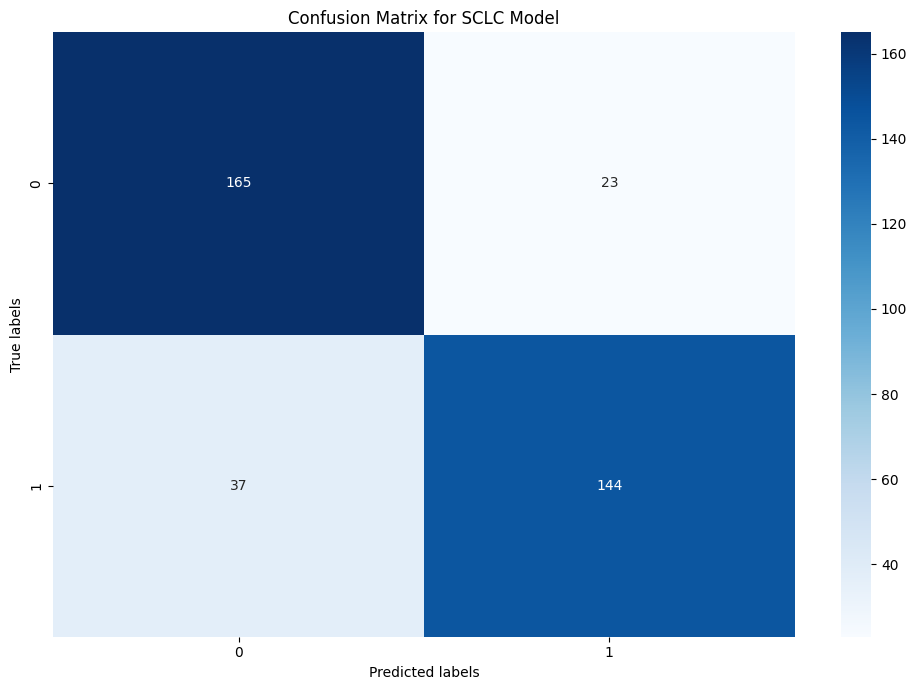

In [20]:
# Create a confusion matrix visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm_sclc, annot=True, fmt='g', cmap='Blues')

# Adding labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for SCLC Model')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

In [21]:
test_input = data.iloc[12238:12257,:]
test_input

,Name,FC,logFC,logCPM,P-Value,FDR,SCLC,NSCLC
12238,FAR2,-1.036364,-0.051530,6.047611,0.768052,0.889167,0.0,0.0
12239,ATF6,-1.074289,-0.103382,8.154670,0.260387,0.490329,1.0,0.0
12240,ATF3,-1.197653,-0.260209,6.107613,0.301848,0.533602,1.0,0.0
12241,LOC441087,1.365118,0.449026,-1.056675,0.084938,0.258926,0.0,0.0
12242,GATA6,-1.275932,-0.351551,4.885739,0.114056,0.305799,0.0,0.0
12243,TPRG1L,1.004909,0.007065,4.665519,0.976440,0.994635,0.0,0.0
12244,PDGFA,-1.243270,-0.314139,4.715532,0.088348,0.265474,1.0,1.0
12245,GATA2,1.032892,0.046689,2.803374,0.842767,0.931684,0.0,0.0
12246,CIAO3,-1.148757,-0.200073,3.933105,0.075367,0.242021,0.0,0.0
12247,CIAO1,1.123722,0.168285,5.935793,0.131505,0.332089,0.0,0.0


In [22]:
# Setting up and training the final models
rfc_sclc = pipeline.set_params(**best_params_sclc)
rfc_sclc.fit(xtrain_sclc, ytrain_sclc)

rfc_nsclc = pipeline.set_params(**best_params_nsclc)
rfc_nsclc.fit(xtrain_nsclc, ytrain_nsclc)


def predict_biomarkers(test_input):
    # Assuming 'Name', 'FC', 'P-Value', 'SCLC', and 'NSCLC' are present in the DataFrame

    test_input['NSCLC'] = test_input['NSCLC'].fillna(0)
    test_input['SCLC'] = test_input['SCLC'].fillna(0)

    # Selecting the desired columns for test_x
    text_x = test_input[['FC', 'logFC', 'P-Value']]

    # Selecting the desired column for test_y_sclc
    test_y_sclc = test_input['SCLC']

    # Selecting the desired column for test_y_nsclc
    test_y_nsclc = test_input['NSCLC']

    sc_x = StandardScaler()
    test_x = sc_x.fit_transform(text_x)

    rfc_predict_sclc = np.array(rfc_sclc.predict(test_x))
    rfc_predict_nsclc = np.array(rfc_nsclc.predict(test_x))
    common_biomarkers = (rfc_predict_sclc == 1) & (rfc_predict_nsclc == 1)
    common_biomarkers = common_biomarkers.astype(int)

    return rfc_predict_sclc, rfc_predict_nsclc, common_biomarkers

rfc_predict_sclc, rfc_predict_nsclc, common_biomarkers = predict_biomarkers(test_input)

# Print the predicted biomarkers
print("SCLC Biomarkers")
for (i, val) in enumerate(rfc_predict_sclc):
    if val == 1:
        if test_input.iloc[i, :]['SCLC'] == 1.0:
            print(test_input.iloc[i, :]['Name'])

print("\nNSCLC Biomarkers")
for (i, val) in enumerate(rfc_predict_nsclc):
    if val == 1:
        if test_input.iloc[i, :]['NSCLC'] == 1.0:
            print(test_input.iloc[i, :]['Name'])

print("\nCommon Biomarkers")
for (i, val) in enumerate(common_biomarkers):
    if val == 1:
        if test_input.iloc[i, :]['SCLC'] == 1.0 and test_input.iloc[i, :]['NSCLC'] == 1.0:
            print(test_input.iloc[i, :]['Name'])

SCLC Biomarkers
ATF6
ATF3
PDGFA
PDGFD
PDGFC
PIP5K1C

NSCLC Biomarkers
PDGFA
PDGFD
PDGFC

Common Biomarkers
PDGFA
PDGFD
PDGFC
